# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [39]:
import sys
from pathlib import Path

root_dir = Path().absolute()
# Strip subdirectory if notebook started inside project subfolders
if root_dir.parts[-1:] == ('airquality',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('local_notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('collab_notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from airquality.config import HopsworksSettings
settings = HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning
HopsworksSettings initialized!


In [40]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from airquality import util
import os
import numpy as np


In [41]:
today = datetime.now() - timedelta(0)
tomorrow = today + timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 15, 55, 55, 297475)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [42]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

street

2025-11-18 15:55:55,313 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 15:55:55,315 INFO: Initializing external client
2025-11-18 15:55:55,315 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 15:55:55,910 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 15:55:56,825 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132


'viktoriagatan'

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [43]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

retrieved_model_lagged = mr.get_model(
    name=f"air_quality_xgboost_lagged_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()
saved_model_dir_lagged = retrieved_model_lagged.download()

2025-11-18 15:56:02,075 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/418584 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122094 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19166 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/263898 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117694 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26703 elapsed<00:00 remaining<?

In [44]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor(
            enable_categorical=True,
            tree_method="hist")
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

retrieved_xgboost_model_lagged = XGBRegressor(
            enable_categorical=True,
            tree_method="hist")
retrieved_xgboost_model_lagged.load_model(saved_model_dir_lagged + f"/model.json")


# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model
retrieved_xgboost_model_lagged

,objective,'reg:squarederror'
,base_score,'2.2625841E1'
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [45]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name=f'air_quality',
    version=2,
)
# Get data from the last 7 days to ensure we have enough history for lagged features
lookback_days = 7
start_date = (today - timedelta(days=lookback_days)).replace(hour=0, minute=0, second=0, microsecond=0)

print(f"Fetching air quality data from {start_date.date()} onwards...")
air_quality_data = air_quality_fg.filter(air_quality_fg.date >= start_date).read()

# Drop url column if it exists
if 'url' in air_quality_data.columns:
    air_quality_data = air_quality_data.drop(columns="url")

print(f"Loaded {len(air_quality_data)} rows of air quality data")
print(f"Date range: {air_quality_data['date'].min()} to {air_quality_data['date'].max()}")

# Get weather forecast data from today onwards
weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')
print(f"Loaded {len(weather_data)} rows of weather forecast data")


# Check what data is actually in the feature group


Fetching air quality data from 2025-11-11 onwards...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 
Loaded 1 rows of air quality data
Date range: 2025-11-16 00:00:00+00:00 to 2025-11-16 00:00:00+00:00
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
Loaded 14 rows of weather forecast data


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [46]:
air_quality_forecast_base = air_quality_data.copy().drop(columns=['pm25_lag1', 'pm25_lag2', 'pm25_lag3']).rename(columns={"pm25": "predicted_pm25"})
air_quality_forecast_lagged = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

print(air_quality_forecast_base)
print(air_quality_forecast_lagged)

# Ensure lagged columns exist
for col in ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']:
    if col not in air_quality_forecast_lagged.columns:
        air_quality_forecast_lagged[col] = None

                       date  predicted_pm25 country                   city  \
0 2025-11-16 00:00:00+00:00             7.0  sweden  skelleftea-kv-pantern   

          street  
0  viktoriagatan  
                       date  predicted_pm25  pm25_lag1  pm25_lag2  pm25_lag3  \
0 2025-11-16 00:00:00+00:00             7.0        NaN        NaN        NaN   

  country                   city         street  
0  sweden  skelleftea-kv-pantern  viktoriagatan  


In [47]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)
    
    # Filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]
    
    # Check if we found matching data
    if last_days_aq.empty:
        print(f"WARNING: No air quality data found for city='{city}' on date={prev_date.date()}")
        print(f"Available dates in air_quality_data: {sorted(air_quality_data['date'].dt.date.unique())}")
        print(f"Available cities: {air_quality_data['city'].unique()}")
        
        # Try to get the most recent data for this city instead
        city_data = air_quality_data[air_quality_data['city'] == city].sort_values('date', ascending=False)
        if not city_data.empty:
            last_days_aq = city_data.head(1)
            print(f"Using most recent data from {last_days_aq['date'].iloc[0]}")
        else:
            return
            #raise ValueError(f"No data available for city '{city}' at all!")
    
    # Extract lagged features if available
    if lagged_available:
        features['pm25_lag3'] = last_days_aq['pm25_lag2'].iloc[0]
        features['pm25_lag2'] = last_days_aq['pm25_lag1'].iloc[0]
        features['pm25_lag1'] = last_days_aq['predicted_pm25'].iloc[0]
    
    features['city'] = city
    features['street'] = last_days_aq['street'].iloc[0]
    features['country'] = last_days_aq['country'].iloc[0]
    features['date'] = pred_date
    
    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        features[col] = row[col]
    
    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [48]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    """Append prediction to air quality forecast data"""
    new_row = prediction_row.copy()
    
    # Extract the scalar value safely
    if isinstance(predicted_pm25, (list, np.ndarray)):
        pm25_value = predicted_pm25[0]
    elif isinstance(predicted_pm25, pd.Series):
        pm25_value = predicted_pm25.iloc[0]
    else:
        pm25_value = predicted_pm25
    
    new_row["predicted_pm25"] = pm25_value
    
    # Only preserve lagged columns if they exist in prediction_row
    if lagged_available:
        for lag_col in ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']:
            if lag_col in prediction_row.columns:
                val = prediction_row[lag_col].iloc[0] if len(prediction_row) > 0 else None
                new_row[lag_col] = val
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, new_row], ignore_index=True)
    return updated_air_quality_data

In [50]:
print("=" * 50)
print("DEBUGGING: City name comparison")
print("=" * 50)
print(f"City from secrets: '{city}'")
print(f"Cities in air_quality_data: {air_quality_data['city'].unique()}")
print(f"Cities in weather_data: {weather_data['city'].unique()}")
print("=" * 50)

# Check if city names match
if city not in air_quality_data['city'].values:
    print(f"ERROR: City '{city}' not found in air_quality data!")
    print("This will cause the prediction loop to fail.")
    
if 'city' in weather_data.columns and city not in weather_data['city'].values:
    print(f"ERROR: City '{city}' not found in weather data!")


for _, prediction in weather_data.iterrows():
        pred_date = pd.to_datetime(prediction['date'])
        prediction_df_base = prepare_prediction_row(prediction, air_quality_forecast_base, lagged_available=False)
        prediction_df_lagged = prepare_prediction_row(prediction, air_quality_forecast_lagged, lagged_available=True)

        if prediction_df_base is None or prediction_df_lagged is None:
            print(f"Skipping prediction for {pred_date.date()} - no historical data available")
            continue
        
        predicted_pm25_base = retrieved_xgboost_model.predict(prediction_df_base[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
        predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

        air_quality_forecast_base = append_predicted_pm25(air_quality_forecast_base, prediction_df_base, predicted_pm25_base, lagged_available=False)
        air_quality_forecast_lagged = append_predicted_pm25(air_quality_forecast_lagged, prediction_df_lagged, predicted_pm25_lagged, lagged_available=True)

weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_base[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_base["date"] = pd.to_datetime(air_quality_forecast_base["date"]).dt.tz_convert(None)
air_quality_forecast_base['days_before_forecast_day'] = (air_quality_forecast_base["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_base = air_quality_forecast_base[air_quality_forecast_base['days_before_forecast_day'] > 0]

weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_lagged[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_lagged["date"] = pd.to_datetime(air_quality_forecast_lagged["date"]).dt.tz_convert(None)
air_quality_forecast_lagged['days_before_forecast_day'] = (air_quality_forecast_lagged["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_lagged = air_quality_forecast_lagged[air_quality_forecast_lagged['days_before_forecast_day'] > 0]

DEBUGGING: City name comparison
City from secrets: 'skelleftea-kv-pantern'
Cities in air_quality_data: ['skelleftea-kv-pantern']
Cities in weather_data: ['skelleftea-kv-pantern' 'vindeln' '']
Available dates in air_quality_data: [datetime.date(2025, 11, 16), datetime.date(2025, 11, 19)]
Available cities: ['skelleftea-kv-pantern']
Using most recent data from 2025-11-19 00:00:00+00:00
Available dates in air_quality_data: [datetime.date(2025, 11, 16), datetime.date(2025, 11, 19)]
Available cities: ['skelleftea-kv-pantern']
Using most recent data from 2025-11-19 00:00:00+00:00
Available dates in air_quality_data: [datetime.date(2025, 11, 16), datetime.date(2025, 11, 19)]
Available cities: ['skelleftea-kv-pantern']
Available dates in air_quality_data: [datetime.date(2025, 11, 16), datetime.date(2025, 11, 19)]
Available cities: ['skelleftea-kv-pantern']
Skipping prediction for 2025-11-19 - no historical data available
Available dates in air_quality_data: [datetime.date(2025, 11, 16), datetim

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

'Resources/airquality/skelleftea-kv-pantern_viktoriagatan_2025-11-18/pm25_forecast.png'

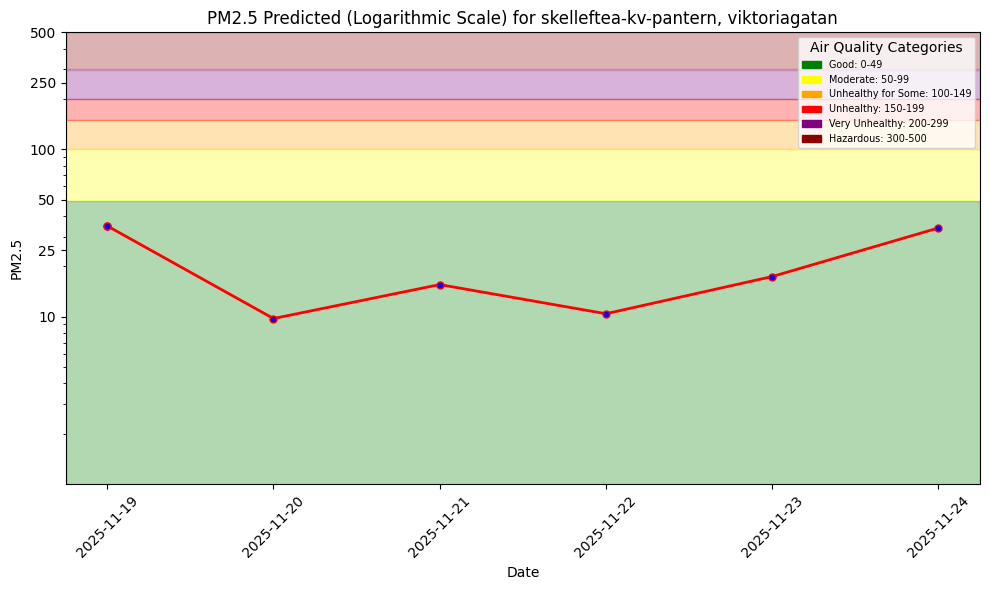

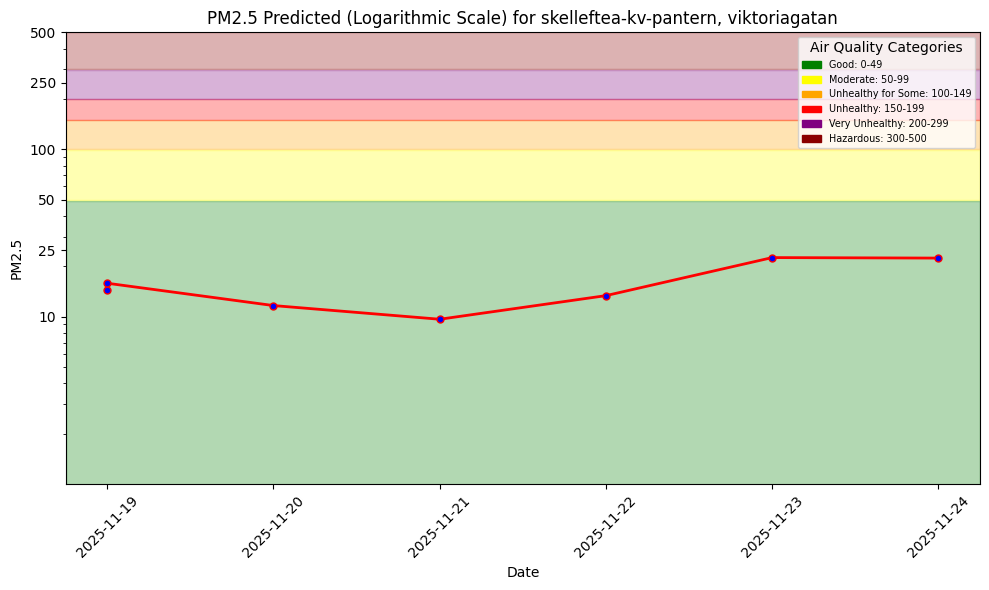

In [51]:
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_base[air_quality_forecast_base['city'] == city], pred_file_path)

pred_file_path_lagged = f"{root_dir}/docs/air-quality/assets/img/lagged/pm25_forecast.png"
lagged_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_lagged[air_quality_forecast_lagged['city'] == city], pred_file_path_lagged)

dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(pred_file_path_lagged, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)


Uploading Dataframe: 100.00% |██████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279132/jobs/named/aq_predictions_1_offline_fg_materialization/executions
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279132/fs/1265741/fg/1718997


Uploading Dataframe: 100.00% |██████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279132/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-18 15:57:47,091 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 15:57:50,273 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 15:59:35,092 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 15:59:35,245 INFO: Waiting for log aggregation to finish.
2025-11-18 15:59:50,493 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279132/settings/fb/path/Resources/airquality


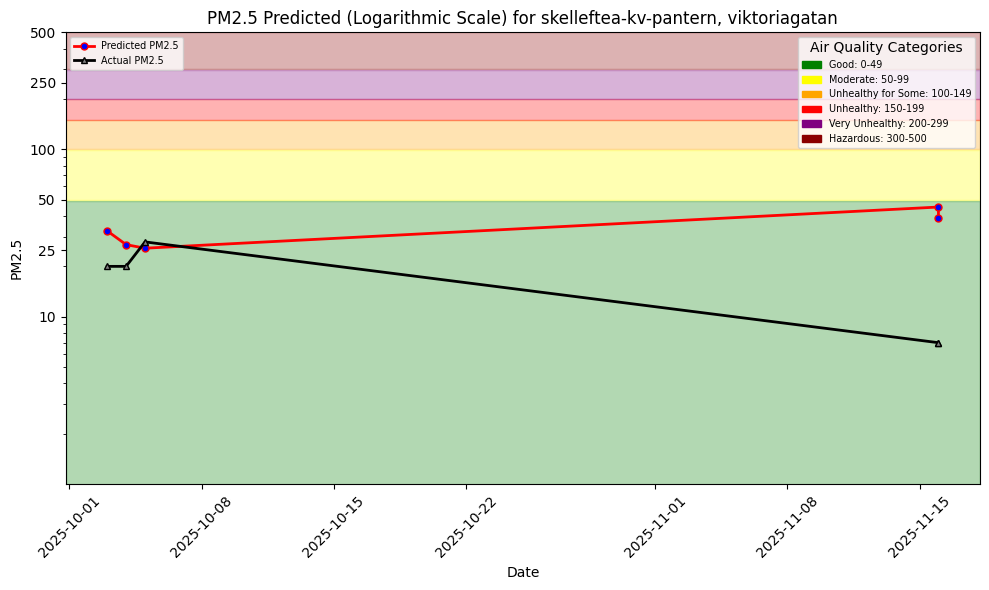

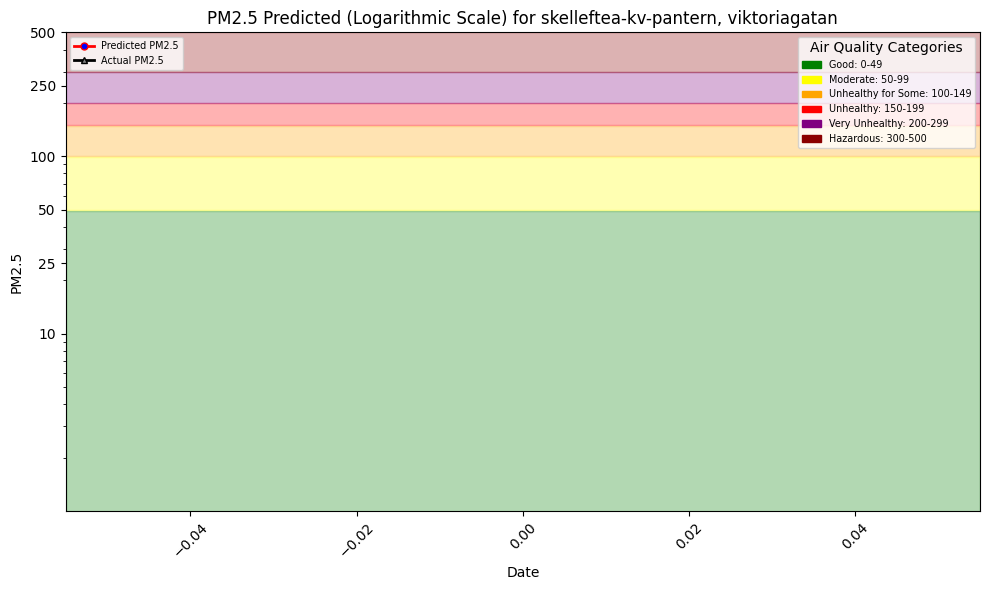

In [52]:
 # Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name=f'aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

monitor_fg_lagged = fs.get_or_create_feature_group(
    name=f'aq_predictions_lagged',
    description='Air Quality prediction monitoring (lagged)',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

monitor_fg.insert(air_quality_forecast_base)
monitor_fg_lagged.insert(air_quality_forecast_lagged, wait=True)

monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day > 0).read()
monitoring_lagged = monitor_fg_lagged.filter(monitor_fg_lagged.days_before_forecast_day > 0).read()

air_quality_fg = fs.get_feature_group(
    name=f'air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()

preds_base =  monitoring_df[['date', 'predicted_pm25', 'city']] if len(monitoring_df) > 0 else pd.DataFrame()
preds_lagged =  monitoring_lagged[['date', 'predicted_pm25', 'city']] if len(monitoring_lagged) > 0 else pd.DataFrame()

hindcast_base = pd.merge(preds_base, air_quality_df, on=["date", "city"])
hindcast_base = hindcast_base.sort_values(by=['date'])

hindcast_lagged = pd.merge(preds_lagged, air_quality_df, on=["date", "city"])
hindcast_lagged = hindcast_lagged.sort_values(by=['date'])

hindcast_location_base = hindcast_base[hindcast_base['city'] == city]
hindcast_location_lagged = hindcast_lagged[hindcast_lagged['city'] == city]

hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
lagged_file_path = f"{root_dir}/docs/air-quality/assets/img/lagged/pm25_hindcast_1day.png"

plt = util.plot_air_quality_forecast(city, street, hindcast_location_base, hindcast_file_path, hindcast=True)
lagged_plt = util.plot_air_quality_forecast(city, street, hindcast_location_lagged, lagged_file_path, hindcast=True)

dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(lagged_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")


---

# WAIT, there's more...

## A-grade: run inference on each file
We need to make sure to execute the above cells for each of the sensors that we can find in the Skelleftea area 

In [53]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)

    # filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]

    # Add location info
    if not last_days_aq.empty:
        features['street'] = last_days_aq['street'].iloc[0]
        features['country'] = last_days_aq['country'].iloc[0]
    else:
        features['street'] = 'Unknown'
        features['country'] = 'Unknown'
    
    features['city'] = city
    features['date'] = pred_date

    # Add lagged features if available
    if lagged_available:
        if not last_days_aq.empty and 'predicted_pm25' in last_days_aq.columns:
            features['lagged_1'] = last_days_aq['predicted_pm25'].iloc[0]
            features['lagged_2'] = last_days_aq['lagged_1'].iloc[0] if not last_days_aq.empty and 'lagged_1' in last_days_aq.columns else None
            features['lagged_3'] = last_days_aq['lagged_2'].iloc[0] if not last_days_aq.empty and 'lagged_2' in last_days_aq.columns else None
        else:
            features['lagged_1'] = None
            features['lagged_2'] = None
            features['lagged_3'] = None

    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        if col in row.index:
            features[col] = row[col]
        else:
            features[col] = None

    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [54]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    """Append prediction to air quality forecast data"""
    new_row = prediction_row.copy()
    
    # Extract the scalar value safely
    if isinstance(predicted_pm25, (list, np.ndarray)):
        pm25_value = predicted_pm25[0]
    elif isinstance(predicted_pm25, pd.Series):
        pm25_value = predicted_pm25.iloc[0]
    else:
        pm25_value = predicted_pm25
    
    new_row["predicted_pm25"] = pm25_value
    
    # Only preserve lagged columns if they exist in prediction_row
    if lagged_available:
        for lag_col in ['lagged_1', 'lagged_2', 'lagged_3']:
            if lag_col in prediction_row.columns:
                val = prediction_row[lag_col].iloc[0] if len(prediction_row) > 0 else None
                new_row[lag_col] = val
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, new_row], ignore_index=True)
    return updated_air_quality_data

In [55]:
try:
    extra_sensors = f"{root_dir}/data/extra_sensors/"
    util.check_data_folder_structure(root_dir)

    project = hopsworks.login()
    fs = project.get_feature_store() 
    secrets = hopsworks.get_secrets_api()

    import json

    try:
        with open(f"{root_dir}/data/extra_sensor_settings.json", 'r') as file:
            settings_json = json.load(file)["extra_sensors"]
    except FileNotFoundError:
        print("Settings file for extra sensors not found.")
        sys.exit(1)

    for csv_file_name in os.listdir(extra_sensors):

        if settings.HOPSWORKS_API_KEY is not None:
            api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
            os.environ['HOPSWORKS_API_KEY'] = api_key

        project = hopsworks.login()
        fs = project.get_feature_store() 

        secrets = hopsworks.get_secrets_api()
        location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{csv_file_name}").value
        location = json.loads(location_str)
        country=location['country']
        city=location['city']
        street=location['street']

        mr = project.get_model_registry()

        ####################
        import re
        ####################
        # Retrieve feature groups
        # split the .csv extension from the csv_file_name: not compatible with Hopsworks feature group names
        csv_file_name_no_ext = os.path.splitext(csv_file_name)[0]
        # replace - with _
        csv_file_name_no_ext = re.sub(r'[-\s]', '_', csv_file_name_no_ext)

        retrieved_model = mr.get_model(
            name=f"air_quality_xgboost_model_{csv_file_name_no_ext}",
            version=1,
        )

        retrieved_model_lagged = mr.get_model(
            name=f"air_quality_xgboost_lagged_model_{csv_file_name_no_ext}",
            version=1,
        )


        fv = retrieved_model.get_feature_view()

        # Download the saved model artifacts to a local directory
        saved_model_dir = retrieved_model.download()
        saved_model_dir_lagged = retrieved_model_lagged.download()

        # Loading the XGBoost regressor model and label encoder from the saved model directory
        # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
        retrieved_xgboost_model = XGBRegressor()
        retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{csv_file_name_no_ext}.json")
        
        retrieved_xgboost_model_lagged = XGBRegressor()
        retrieved_xgboost_model_lagged.load_model(saved_model_dir_lagged + f"/model_{csv_file_name_no_ext}.json")

        weather_fg = fs.get_feature_group(
            name=f'weather_{csv_file_name_no_ext}',
            version=1,
        )

        air_quality_fg = fs.get_feature_group(
            name=f'air_quality_{csv_file_name_no_ext}',
            version=2,
        )

        yesterday_2359 = (today - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
        air_quality_data = air_quality_fg.filter(air_quality_fg.date >= yesterday_2359.date()).read().drop(columns="url")
        weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')

        air_quality_forecast_base = air_quality_data.copy().drop(columns=['lagged_1', 'lagged_2', 'lagged_3']).rename(columns={"pm25": "predicted_pm25"})
        air_quality_forecast_lagged = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

        # Ensure lagged columns exist
        for col in ['lagged_1', 'lagged_2', 'lagged_3']:
            if col not in air_quality_forecast_lagged.columns:
                air_quality_forecast_lagged[col] = None

        for _, prediction in weather_data.iterrows():
            pred_date = pd.to_datetime(prediction['date'])
            prediction_df_base = prepare_prediction_row(prediction, air_quality_forecast_base, lagged_available=False)
            prediction_df_lagged = prepare_prediction_row(prediction, air_quality_forecast_lagged, lagged_available=True)
            
            predicted_pm25_base = retrieved_xgboost_model.predict(prediction_df_base[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
            predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

            air_quality_forecast_base = append_predicted_pm25(air_quality_forecast_base, prediction_df_base, predicted_pm25_base, lagged_available=False)
            air_quality_forecast_lagged = append_predicted_pm25(air_quality_forecast_lagged, prediction_df_lagged, predicted_pm25_lagged, lagged_available=True)

        weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
        air_quality_forecast_base[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
        air_quality_forecast_base["date"] = pd.to_datetime(air_quality_forecast_base["date"]).dt.tz_convert(None)
        air_quality_forecast_base['days_before_forecast_day'] = (air_quality_forecast_base["date"] - pd.Timestamp(today).normalize()).dt.days
        air_quality_forecast_base = air_quality_forecast_base[air_quality_forecast_base['days_before_forecast_day'] > 0]

        weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
        air_quality_forecast_lagged[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
        air_quality_forecast_lagged["date"] = pd.to_datetime(air_quality_forecast_lagged["date"]).dt.tz_convert(None)
        air_quality_forecast_lagged['days_before_forecast_day'] = (air_quality_forecast_lagged["date"] - pd.Timestamp(today).normalize()).dt.days
        air_quality_forecast_lagged = air_quality_forecast_lagged[air_quality_forecast_lagged['days_before_forecast_day'] > 0]

        pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{csv_file_name_no_ext}.png"
        plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_base[air_quality_forecast_base['city'] == city], pred_file_path)

        pred_file_path_lagged = f"{root_dir}/docs/air-quality/assets/img/lagged/pm25_forecast_{csv_file_name_no_ext}.png"
        lagged_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_lagged[air_quality_forecast_lagged['city'] == city], pred_file_path_lagged)

        dataset_api = project.get_dataset_api()
        str_today = today.strftime("%Y-%m-%d")
        if dataset_api.exists("Resources/airquality") == False:
            dataset_api.mkdir("Resources/airquality")
        dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
        dataset_api.upload(pred_file_path_lagged, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

        # Get or create feature group
        monitor_fg = fs.get_or_create_feature_group(
            name=f'aq_predictions_{csv_file_name_no_ext}',
            description='Air Quality prediction monitoring',
            version=1,
            primary_key=['city','street','country','days_before_forecast_day'],
            event_time="date"
        )

        monitor_fg_lagged = fs.get_or_create_feature_group(
            name=f'aq_predictions_lagged_{csv_file_name_no_ext}',
            description='Air Quality prediction monitoring (lagged)',
            version=1,
            primary_key=['city','street','country','days_before_forecast_day'],
            event_time="date"
        )

        monitor_fg.insert(air_quality_forecast_base)
        monitor_fg_lagged.insert(air_quality_forecast_lagged, wait=True)
   
        monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day > 0).read()
        monitoring_lagged = monitor_fg_lagged.filter(monitor_fg_lagged.days_before_forecast_day > 0).read()

        air_quality_fg = fs.get_feature_group(
            name=f'air_quality_{csv_file_name_no_ext}',
            version=2,
        )
        air_quality_df = air_quality_fg.read()

        preds_base =  monitoring_df[['date', 'predicted_pm25', 'city']] if len(monitoring_df) > 0 else pd.DataFrame()
        preds_lagged =  monitoring_lagged[['date', 'predicted_pm25', 'city']] if len(monitoring_lagged) > 0 else pd.DataFrame()

        hindcast_base = pd.merge(preds_base, air_quality_df, on=["date", "city"])
        hindcast_base = hindcast_base.sort_values(by=['date'])

        hindcast_lagged = pd.merge(preds_lagged, air_quality_df, on=["date", "city"])
        hindcast_lagged = hindcast_lagged.sort_values(by=['date'])

        hindcast_location_base = hindcast_base[hindcast_base['city'] == city]
        hindcast_location_lagged = hindcast_lagged[hindcast_lagged['city'] == city]

        hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{csv_file_name_no_ext}.png"
        lagged_file_path = f"{root_dir}/docs/air-quality/assets/img/lagged/pm25_hindcast_1day_{csv_file_name_no_ext}.png"

        plt = util.plot_air_quality_forecast(city, street, hindcast_location_base, hindcast_file_path, hindcast=True)
        lagged_plt = util.plot_air_quality_forecast(city, street, hindcast_location_lagged, lagged_file_path, hindcast=True)

        dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{csv_file_name_no_ext}", overwrite=True)
        dataset_api.upload(lagged_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{csv_file_name_no_ext}", overwrite=True)

        proj_url = project.get_url()
        print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

except Exception as e:
    import traceback
    print(f"An error occurred while processing extra sensors: {e}")
    print("\n=== FULL TRACEBACK ===")
    traceback.print_exc()


Checking data folder structure at path: /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning/data/extra_sensors
Data folder structure is correct.
2025-11-18 16:00:02,061 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 16:00:02,065 INFO: Initializing external client
2025-11-18 16:00:02,066 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 16:00:02,661 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 16:00:03,461 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132
2025-11-18 16:00:04,400 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 16:00:04,403 INFO: Initializing external client
2025-11-18 16:00:04,403 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 16:00:05,850 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132
2025-11-18 16:00:10,541 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/417372 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122111 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19590 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/415644 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/41965 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19451 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 
An error occurred while processing extra sensors: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:lagged_1: object, lagged_2: object, lagged_3: object, city: category

=== FULL TRACEBACK ===


Traceback (most recent call last):
  File "/var/folders/5h/9qb1rmhn2d1_5w37v3jzw1_w0000gn/T/ipykernel_27517/4250611457.py", line 98, in <module>
    predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1168, in predict
    predts = self.get_booster().inplace_predict(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-lear